In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt
import os
import json

In [3]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda:0


In [4]:
# Download and load the CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

# Split train data into train and validation
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_dataset, val_dataset = random_split(train_set, [train_size, val_size])

batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Function to set a random seed for reproducibility
def set_seed(seed=None):
    if seed is None:
        seed = np.random.randint(0, 10000)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    return seed

In [6]:
# Function for validation
def validate(net, val_loader, criterion):
    total_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(val_loader)

In [7]:
# Function to calculate test error
def calculate_test_error(net, test_loader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    return 100 - test_accuracy  # Test error

In [8]:
# Function for training
def train_model(net, train_loader, val_loader, test_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []
    test_errors = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        train_losses.append(running_loss / len(train_loader))
        val_loss = validate(net, val_loader, criterion)
        val_losses.append(val_loss)
        test_error = calculate_test_error(net, test_loader)
        test_errors.append(test_error)
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, Test Error: {test_errors[-1]}')

    return train_losses, val_losses, test_errors

In [9]:
# Function to calculate accuracy, F1 score, and recall
def calculate_metrics(net, loader):
    net.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    return accuracy, f1, recall

In [10]:
# ResNet-18 with SE block

# SE block
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


def initialize_model(device):
    net = models.resnet18(weights=None)
    num_features = net.fc.in_features

    # Adding an SE block
    net.avgpool = nn.Sequential(net.avgpool, SEBlock(num_features))

    # Adjusting for 10 classes in CIFAR-10
    net.fc = torch.nn.Linear(num_features, 10)
    net = net.to(device)

    return net

In [11]:
def initialize_loss_function():
    return nn.CrossEntropyLoss()

In [12]:
def initialize_optimizer(model_params):
    return optim.SGD(model_params, lr=0.001)

Run: 1
Seed: 3045
Epoch 1/200, Train Loss: 2.3100716948509215, Validation Loss: 2.290956401824951, Test Error: 87.0
Epoch 2/200, Train Loss: 2.2581175684928896, Validation Loss: 2.2304134130477906, Test Error: 81.39
Epoch 3/200, Train Loss: 2.195476680994034, Validation Loss: 2.1714478492736817, Test Error: 77.57
Epoch 4/200, Train Loss: 2.12636593580246, Validation Loss: 2.102423882484436, Test Error: 74.38
Epoch 5/200, Train Loss: 2.0528706133365633, Validation Loss: 2.0359140157699587, Test Error: 72.77
Epoch 6/200, Train Loss: 1.9770706653594972, Validation Loss: 1.9717105746269226, Test Error: 70.68
Epoch 7/200, Train Loss: 1.9159767538309098, Validation Loss: 1.9143394947052002, Test Error: 69.16
Epoch 8/200, Train Loss: 1.8561091512441634, Validation Loss: 1.8659281015396119, Test Error: 66.99000000000001
Epoch 9/200, Train Loss: 1.8047815054655074, Validation Loss: 1.8263563752174377, Test Error: 66.34
Epoch 10/200, Train Loss: 1.755655398964882, Validation Loss: 1.783608555793

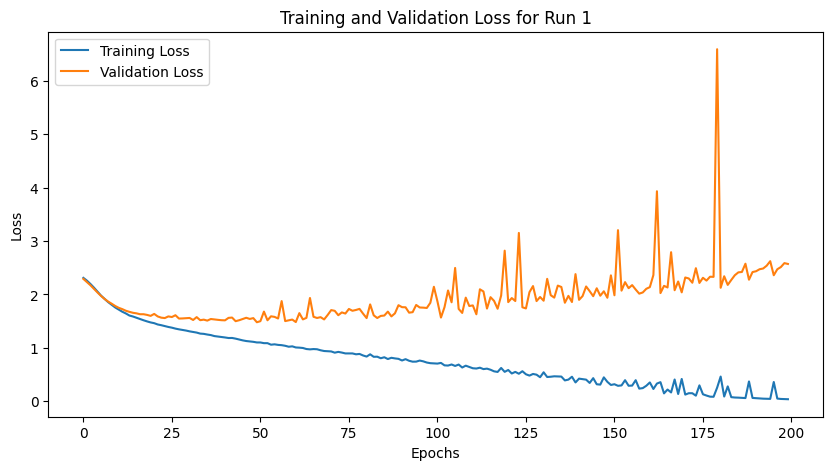

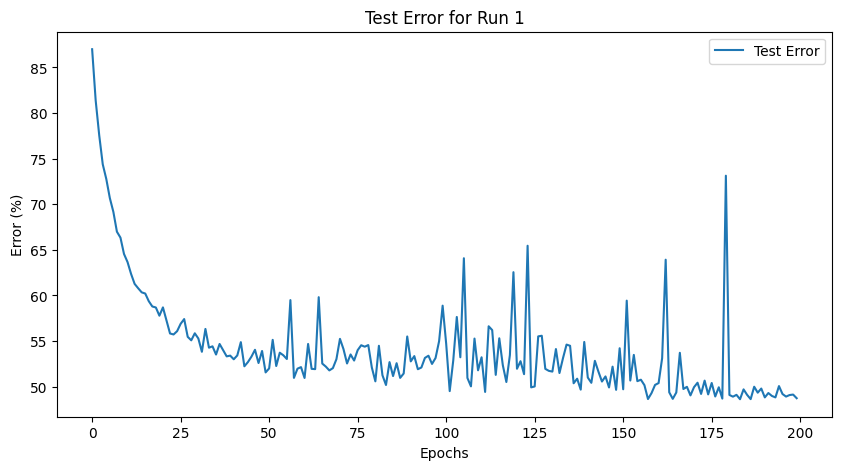

Run: 2
Seed: 8341
Epoch 1/200, Train Loss: 2.322884166240692, Validation Loss: 2.2948088884353637, Test Error: 85.37
Epoch 2/200, Train Loss: 2.252248251438141, Validation Loss: 2.2179909467697145, Test Error: 81.27
Epoch 3/200, Train Loss: 2.1738206923007963, Validation Loss: 2.1455385446548463, Test Error: 78.7
Epoch 4/200, Train Loss: 2.095508351922035, Validation Loss: 2.07442991733551, Test Error: 76.08
Epoch 5/200, Train Loss: 2.024310913681984, Validation Loss: 2.0084903240203857, Test Error: 73.09
Epoch 6/200, Train Loss: 1.9549321621656417, Validation Loss: 1.9525436997413634, Test Error: 70.67
Epoch 7/200, Train Loss: 1.8958929002285003, Validation Loss: 1.904860019683838, Test Error: 68.8
Epoch 8/200, Train Loss: 1.8443070262670518, Validation Loss: 1.8588941812515258, Test Error: 67.3
Epoch 9/200, Train Loss: 1.7957843363285064, Validation Loss: 1.8195212960243226, Test Error: 65.75
Epoch 10/200, Train Loss: 1.7524382382631303, Validation Loss: 1.7777076363563538, Test Erro

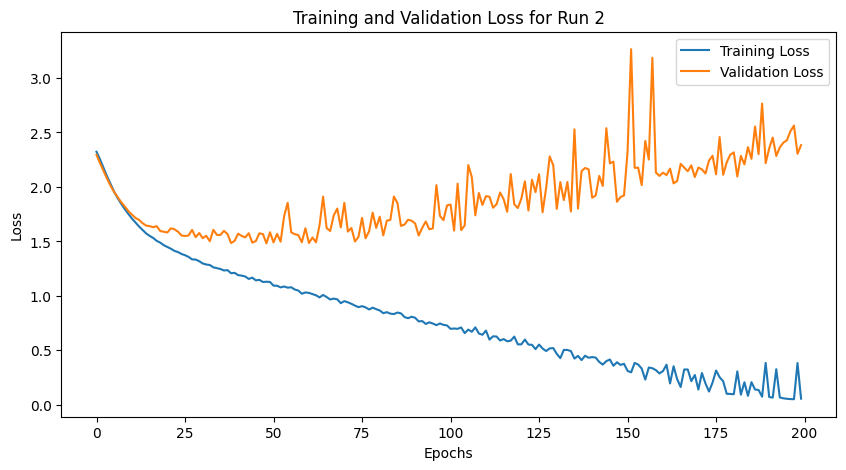

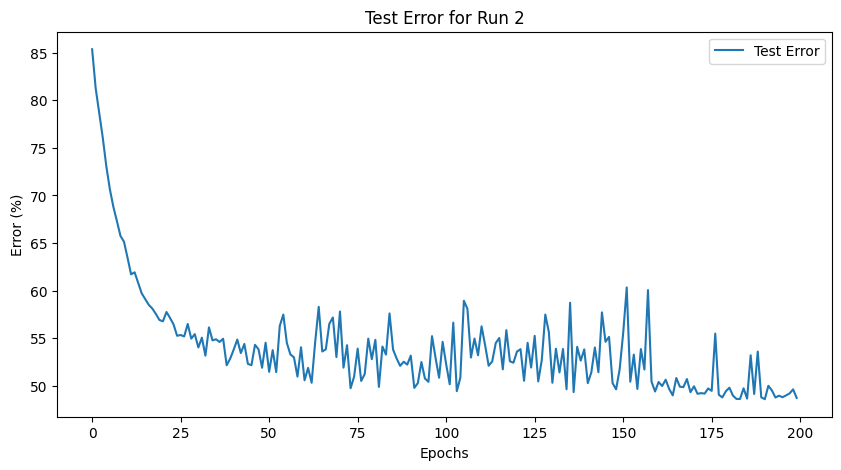

Run: 3
Seed: 7600
Epoch 1/200, Train Loss: 2.3276436567306518, Validation Loss: 2.3013961553573608, Test Error: 88.75
Epoch 2/200, Train Loss: 2.2717793703079225, Validation Loss: 2.244802474975586, Test Error: 82.99
Epoch 3/200, Train Loss: 2.2113747537136077, Validation Loss: 2.1879865407943724, Test Error: 77.97
Epoch 4/200, Train Loss: 2.1476390838623045, Validation Loss: 2.1279787540435793, Test Error: 75.03
Epoch 5/200, Train Loss: 2.080615681409836, Validation Loss: 2.063070607185364, Test Error: 72.78999999999999
Epoch 6/200, Train Loss: 2.011093497276306, Validation Loss: 2.0000981211662294, Test Error: 70.42
Epoch 7/200, Train Loss: 1.949136158823967, Validation Loss: 1.9427518367767334, Test Error: 69.05
Epoch 8/200, Train Loss: 1.88728865981102, Validation Loss: 1.8905762076377868, Test Error: 67.07
Epoch 9/200, Train Loss: 1.8332869023084641, Validation Loss: 1.8424539685249328, Test Error: 65.53999999999999
Epoch 10/200, Train Loss: 1.787743216753006, Validation Loss: 1.8

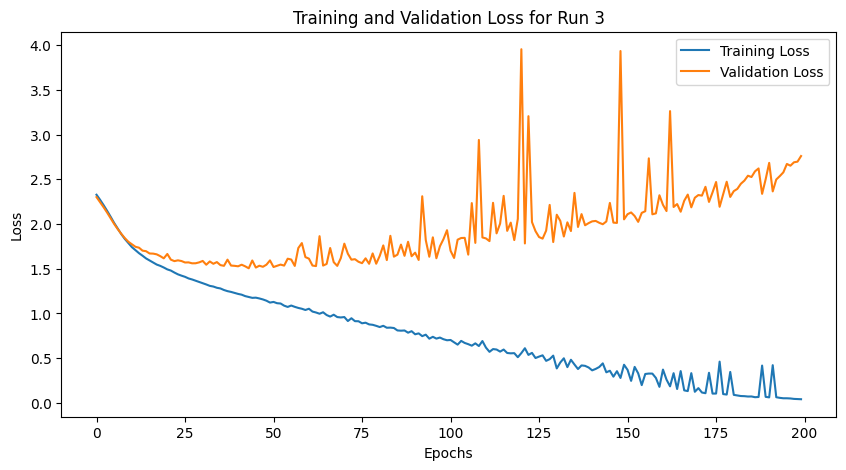

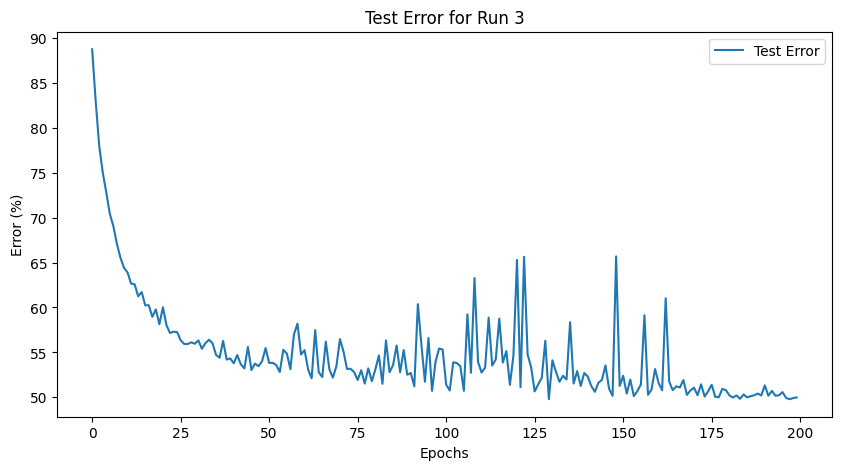

Run: 4
Seed: 6906
Epoch 1/200, Train Loss: 2.321878582239151, Validation Loss: 2.2985998153686524, Test Error: 87.46000000000001
Epoch 2/200, Train Loss: 2.246565043926239, Validation Loss: 2.213889145851135, Test Error: 80.78
Epoch 3/200, Train Loss: 2.168047899007797, Validation Loss: 2.149163603782654, Test Error: 77.14
Epoch 4/200, Train Loss: 2.1022100865840914, Validation Loss: 2.086952328681946, Test Error: 74.52
Epoch 5/200, Train Loss: 2.0374004006385804, Validation Loss: 2.032023477554321, Test Error: 72.3
Epoch 6/200, Train Loss: 1.9766333103179932, Validation Loss: 1.977392566204071, Test Error: 70.88
Epoch 7/200, Train Loss: 1.9234975039958955, Validation Loss: 1.9318690299987793, Test Error: 69.34
Epoch 8/200, Train Loss: 1.8763735592365265, Validation Loss: 1.8922980189323426, Test Error: 68.15
Epoch 9/200, Train Loss: 1.829328289628029, Validation Loss: 1.8497570633888245, Test Error: 65.91
Epoch 10/200, Train Loss: 1.7843990534543992, Validation Loss: 1.821289288997650

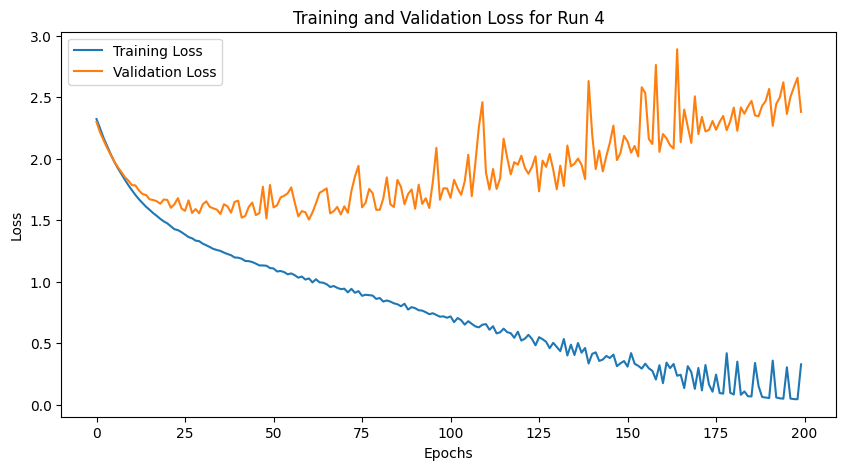

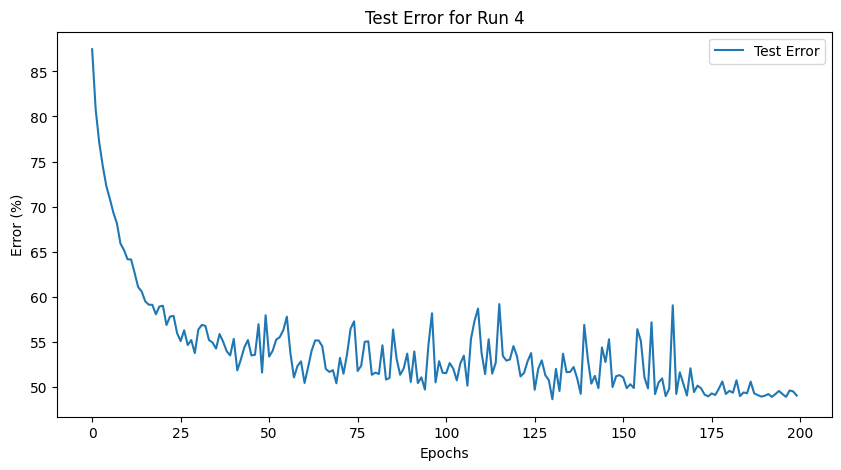

Run: 5
Seed: 6795
Epoch 1/200, Train Loss: 2.3626234114170073, Validation Loss: 2.3271796464920045, Test Error: 88.69
Epoch 2/200, Train Loss: 2.281635719537735, Validation Loss: 2.2469967126846315, Test Error: 82.66
Epoch 3/200, Train Loss: 2.2088935315608977, Validation Loss: 2.1842061996459963, Test Error: 79.12
Epoch 4/200, Train Loss: 2.1437537014484405, Validation Loss: 2.1223344802856445, Test Error: 76.49
Epoch 5/200, Train Loss: 2.075146406888962, Validation Loss: 2.0610164165496827, Test Error: 74.41
Epoch 6/200, Train Loss: 2.0129422545433044, Validation Loss: 2.0092536211013794, Test Error: 72.46000000000001
Epoch 7/200, Train Loss: 1.9491349130868911, Validation Loss: 1.9535572290420533, Test Error: 70.62
Epoch 8/200, Train Loss: 1.8896775186061858, Validation Loss: 1.8957456588745116, Test Error: 68.55
Epoch 9/200, Train Loss: 1.825930619239807, Validation Loss: 1.8477889776229859, Test Error: 66.88
Epoch 10/200, Train Loss: 1.7741567492485046, Validation Loss: 1.80250335

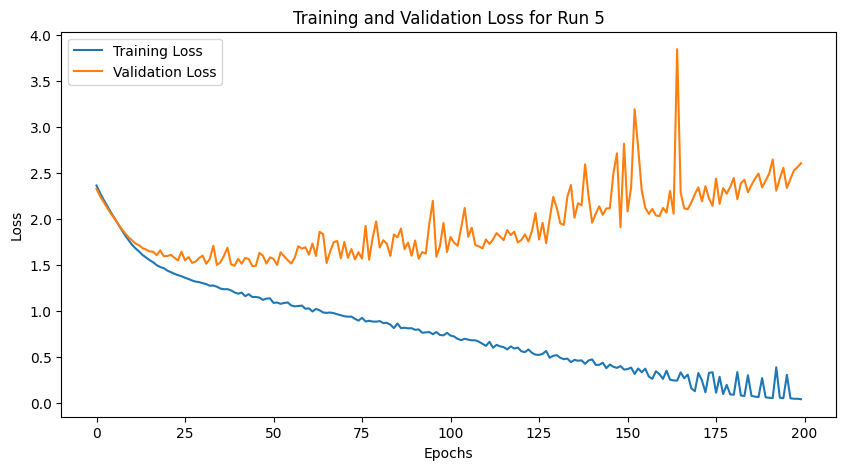

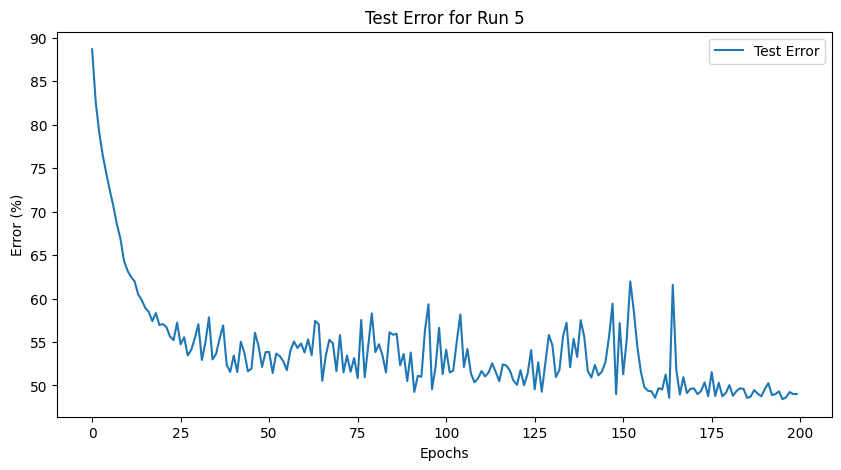

In [13]:
# Run the training for 5 different seeds
num_runs = 5
epochs = 200
metrics = {
    'seed': [],
    'train_losses': [],
    'val_losses': [],
    'test_errors': [],
    'val_accuracy': [],
    'val_f1': [],
    'val_recall': [],
    'test_accuracy': [],
    'test_f1': [],
    'test_recall': []
}



# Initialize dictionaries to store results
results = {
    'train_losses': [],
    'val_losses': [],
    'test_errors': []
}

for run in range(num_runs):
    print(f"Run: {run + 1}")
    seed = set_seed()
    print(f"Seed: {seed}")

    # Reinitialize the model, loss function, and optimizer
    net = initialize_model(device=device)
    criterion = initialize_loss_function()
    optimizer = initialize_optimizer(model_params=net.parameters())

    # Train the network
    train_losses, val_losses, test_errors = train_model(net, train_loader, val_loader, test_loader, criterion, optimizer, epochs)
    metrics['test_errors'].append(test_errors)

    # Calculate metrics on validation and test sets
    val_accuracy, val_f1, val_recall = calculate_metrics(net, val_loader)
    test_accuracy, test_f1, test_recall = calculate_metrics(net, test_loader)
    
    # Print metrics for validation set
    print(f"Run {run + 1} - Validation Metrics:")
    print(f"    Accuracy: {val_accuracy}%")
    print(f"    F1 Score: {val_f1}")
    print(f"    Recall:   {val_recall}")

    # Print metrics for test set
    print(f"Run {run + 1} - Test Metrics:")
    print(f"    Accuracy: {test_accuracy}%")
    print(f"    F1 Score: {test_f1}")
    print(f"    Recall:   {test_recall}")
    
    # Store metrics
    metrics['seed'].append(seed)
    metrics['train_losses'].append(train_losses)
    metrics['val_losses'].append(val_losses)
    metrics['val_accuracy'].append(val_accuracy)
    metrics['val_f1'].append(val_f1)
    metrics['val_recall'].append(val_recall)
    metrics['test_accuracy'].append(test_accuracy)
    metrics['test_f1'].append(test_f1)
    metrics['test_recall'].append(test_recall)
    
    # Append the results for the current run
    results['train_losses'].append(metrics['train_losses'][run])
    results['val_losses'].append(metrics['val_losses'][run])
    results['test_errors'].append(metrics['test_errors'][run])

    # Plot for training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(metrics['train_losses'][run], label='Training Loss')
    plt.plot(metrics['val_losses'][run], label='Validation Loss')
    plt.title(f"Training and Validation Loss for Run {run+1}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot for test error
    plt.figure(figsize=(10, 5))
    plt.plot(metrics['test_errors'][run], label='Test Error')
    plt.title(f"Test Error for Run {run+1}")
    plt.xlabel('Epochs')
    plt.ylabel('Error (%)')
    plt.legend()
    plt.show()

Mean Metrics: {'val_accuracy': 50.322, 'val_f1': 0.5015975097159574, 'val_recall': 0.50322, 'test_accuracy': 50.898, 'test_f1': 0.5065393718513036, 'test_recall': 0.50898}
Standard Deviation of Metrics: {'val_accuracy': 0.5138637951831209, 'val_f1': 0.006998287624055386, 'val_recall': 0.005138637951831218, 'test_accuracy': 0.4654202402130803, 'test_f1': 0.007396453833072042, 'test_recall': 0.004654202402130806}


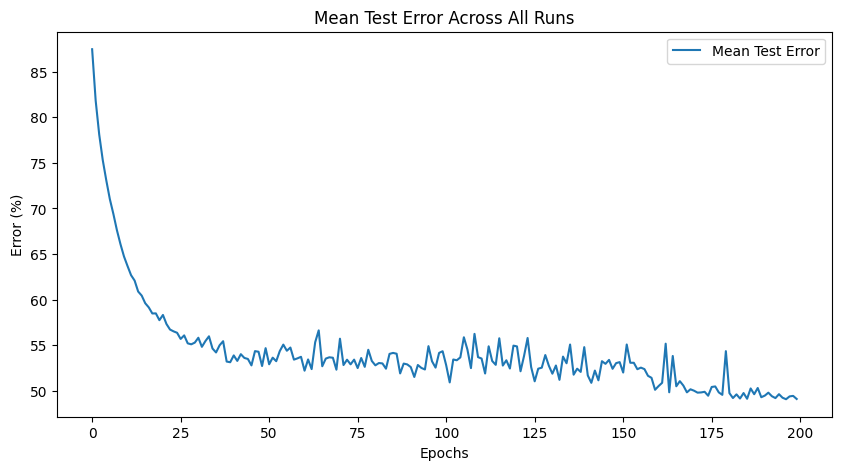

In [14]:
# Calculate mean and standard deviation across runs
mean_metrics = {metric: np.mean(metrics[metric]) for metric in metrics if metric not in ['seed', 'train_losses', 'val_losses', 'test_errors']}
std_metrics = {metric: np.std(metrics[metric]) for metric in metrics if metric not in ['seed', 'train_losses', 'val_losses', 'test_errors']}

# Print mean metrics and standard deviation
print("Mean Metrics:", mean_metrics)
print("Standard Deviation of Metrics:", std_metrics)

# Calculate mean test error across all runs
mean_test_errors = np.mean(metrics['test_errors'], axis=0)

# Plot mean test error
plt.figure(figsize=(10, 5))
plt.plot(mean_test_errors, label='Mean Test Error')
plt.title("Mean Test Error Across All Runs")
plt.xlabel('Epochs')
plt.ylabel('Error (%)')
plt.legend()
plt.show()

In [15]:
# Directory for saving results
save_dir = 'ResNet18_AL_Results'
os.makedirs(save_dir, exist_ok=True)

# Save the results to a file
with open(os.path.join(save_dir, 'SGD.json'), 'w') as f:
    json.dump(results, f)